# Dexamethosone: SI Figure 11

In [1]:
from pathlib import Path

root = Path("../../")
molecule = "dexamethasone"
data_dir = root / "data" / molecule / "1"
output_dir = root / "code" / molecule / "output"

output_dir.mkdir(exist_ok=True, parents=True)

In [2]:
import nmrespy as ne

estimator_path = output_dir / "estimator.pkl"
if estimator_path.is_file():
    estimator = ne.Estimator2DJ.from_pickle(estimator_path)
else:
    estimator = ne.Estimator2DJ.new_bruker(data_dir)
    estimator.phase_data(p0=-2.152, p1=-6.152, pivot=3294)
    estimator.baseline_correction()
    estimator.to_pickle(estimator_path)

In [3]:
import numpy as np

np.random.seed(0)

try:
    estimator.get_results()
except ValueError:
    regions = (
        (7.45, 7.15), (6.40, 5.90), (5.50, 4.80),
        (4.80, 4.30), (4.25, 3.97), (3.00, 2.87),
        (2.68, 2.43), (2.44, 2.26), (2.20, 2.03),
        (1.85, 1.70), (1.70, 1.25), (1.14, 1.00),
        (1.00, 0.65),
    )
    estimate_kwargs = dict(
        noise_region=(7.9, 7.8),
        region_unit="ppm",
        max_iterations=200,
        check_neg_amps_every=25,
        nlp_trim=2028,
    )
    initial_guesses = len(regions) * [None]
    initial_guesses[0] = 2
    initial_guesses[2] = 3
    initial_guesses[4] = 20
    initial_guesses[12] = 3
    for region, initial_guess in zip(regions, initial_guesses):
        estimator.estimate(
            region=region,
            initial_guess=initial_guess,
            **estimate_kwargs,
        )
        estimator.to_pickle(estimator_path, force_overwrite=True)

In [4]:
mp_thold = estimator.sw()[1] / estimator.default_pts[1]

def plot_result(estimator):
    fig, axs = estimator.plot_result(
        region_unit="ppm",
        multiplet_thold=mp_thold,
        multiplet_lw=0.8,
        marker_size=15.0,
        figsize=(20.0, 4.0),
        axes_left=0.05,
        axes_right=0.95,
        axes_bottom=0.1,
        axes_top=0.98,
        contour_base=1.0e3,
        contour_factor=2.0,
        contour_nlevels=10,
        contour_color="#b0b0b0",
        multiplet_show_45=False,
        multiplet_show_center_freq=False,
    )
    
    return fig, axs

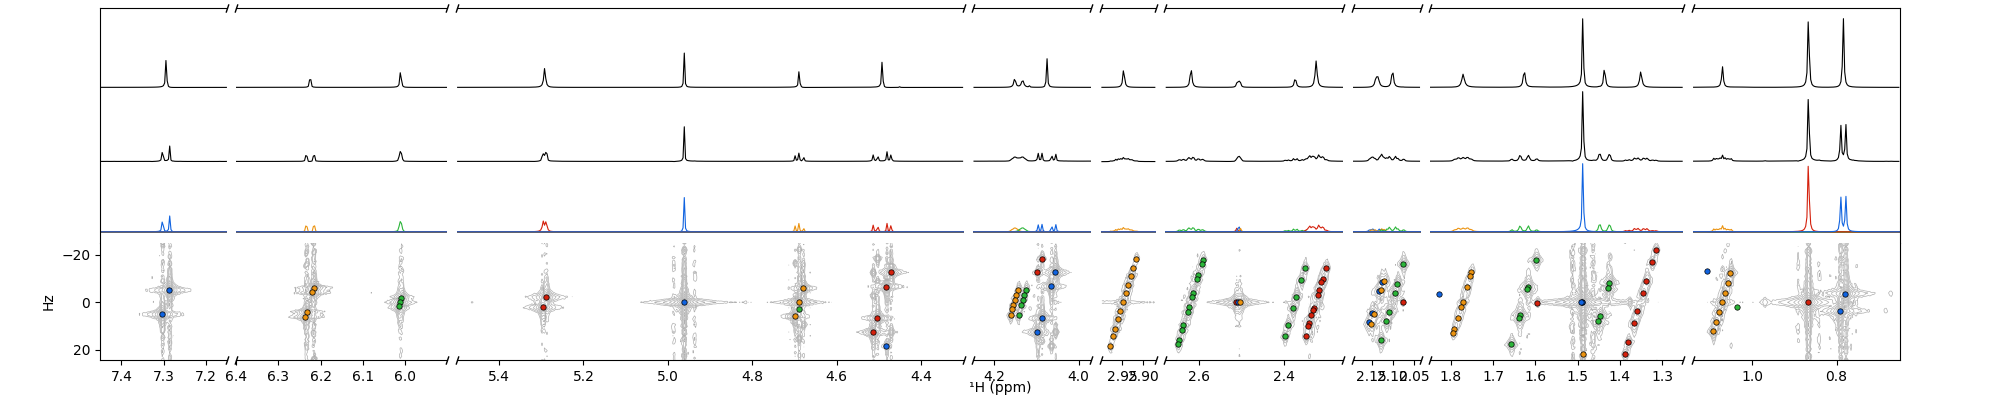

In [5]:
%matplotlib widget
_, _ = plot_result(estimator)

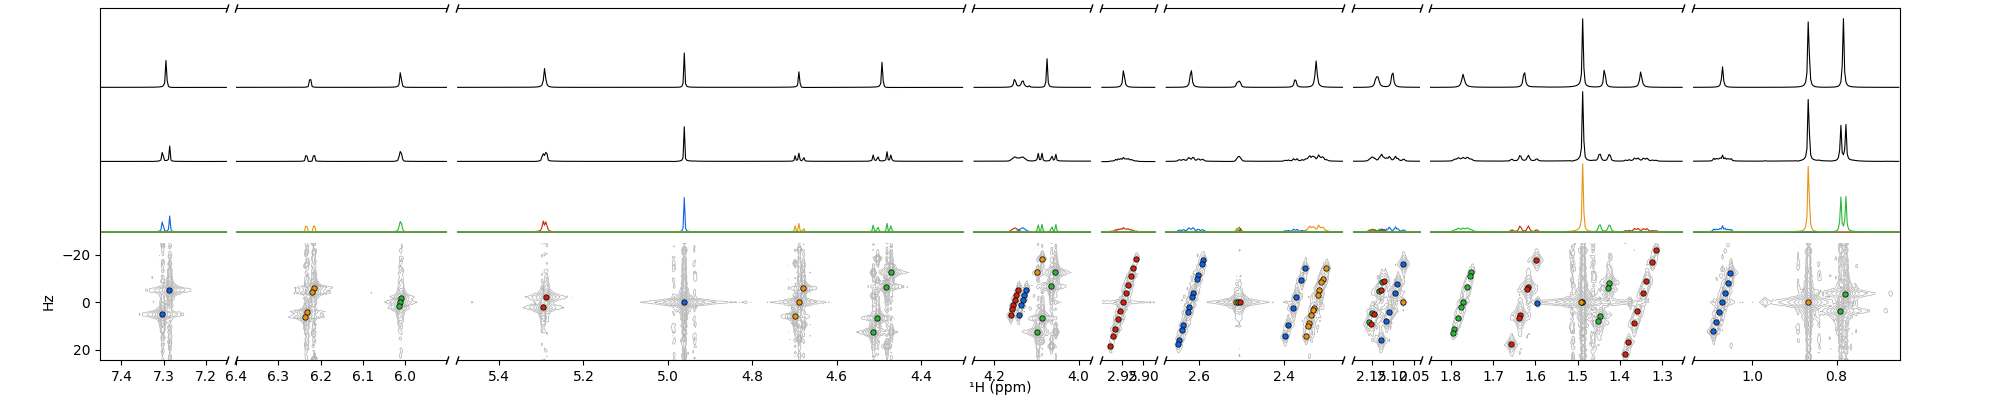

In [6]:
estimator.predict_multiplets(thold=mp_thold, rm_spurious=True)

estimator_final_path = output_dir / "estimator_final.pkl"
if not estimator_final_path.is_file():
    estimator.to_pickle(estimator_final_path)

_, _ = plot_result(estimator)